# Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# Our VAE class
from VariationalModel import *

# Set up

## Tracking Layers

In [3]:
activations = {}
history_encoder = []
history_decoder = []

def get_activation(name):
    """Create a hook that saves the layer output."""
    def hook(module, inputs, output):
        activations[name] = output.detach()
    return hook


def setup_hooks(model):
    """Register forward hooks on encoder, decoder, latent, and output layers."""
    activations.clear()

    # Encoder layers
    for i, layer in enumerate(model.Encoder):
        layer.register_forward_hook(get_activation(f"encoder_layer_{i+1}"))

    # Decoder layers
    for i, layer in enumerate(model.Decoder):
        layer.register_forward_hook(get_activation(f"decoder_layer_{i+1}"))

    # Latent space (Identity module)
    model.LatentSpace.register_forward_hook(get_activation("latent_space"))

    # Output space (Identity module)
    model.OutputSpace.register_forward_hook(get_activation("output_space"))

## Mutual Info (KDE method)

In [4]:
def kde_entropy(data, sigma=0.1):

    # If data are on gpu we need to move to cpu
    if isinstance(data, torch.Tensor): data = data.detach().cpu().numpy()

    N, d = data.shape

    data_sq = np.sum(data**2, axis=1, keepdims=True)
    dists_sq = data_sq + data_sq.T - 2 * np.dot(data, data.T)

    kernel = np.exp(-dists_sq / (2 * sigma**2))
    density = np.mean(kernel, axis=1)

    return -np.mean(np.log(density + 1e-10))


def MutualInfo(layer_data, target_data, sigma=0.1):
    h_layer = kde_entropy(layer_data, sigma)
    h_target = kde_entropy(target_data, sigma)

    joint = np.concatenate([layer_data, target_data], axis=1)
    h_joint = kde_entropy(joint, sigma)

    return h_layer + h_target - h_joint

In [5]:
def VAE_info(model, dataset, device='cpu', num_samples=1000):
    model.eval()
    model.to(device)

    # Take a batch
    loader = torch.utils.data.DataLoader(dataset, batch_size=num_samples, shuffle=True)
    inputs, _ = next(iter(loader))
    inputs = inputs.to(device)

    # Forward pass (hooks will fill activations)
    with torch.no_grad(): outputs, z = model(inputs)

    # Prepare data
    X_data = inputs.view(inputs.size(0), -1).detach().cpu().numpy()
    Z_data = activations["latent_space"].detach().cpu().numpy()
    Y_data = activations["output_space"].detach().cpu().numpy()

    mi = {"encoder": [], "decoder": []}

    # ---------------- ENCODER MI ----------------
    for i in range(1, len(model.Encoder) + 1):
        act = activations[f"encoder_layer_{i}"].detach().cpu().numpy()

        mi["encoder"].append((
            MutualInfo(act, X_data),   # layer vs input
            MutualInfo(act, Z_data)    # layer vs latent
        ))

    # ---------------- DECODER MI ----------------
    for i in range(1, len(model.Decoder) + 1):
        act = activations[f"decoder_layer_{i}"].detach().cpu().numpy()

        mi["decoder"].append((
            MutualInfo(act, Z_data),   # layer vs latent
            MutualInfo(act, Y_data)    # layer vs output
        ))

    return mi

# Dataset

In [6]:
dataDirectory = 'Dataset'

trainDataset = torchvision.datasets.MNIST(dataDirectory, train=True, download=True)
testDataset  = torchvision.datasets.MNIST(dataDirectory, train=False, download=True)

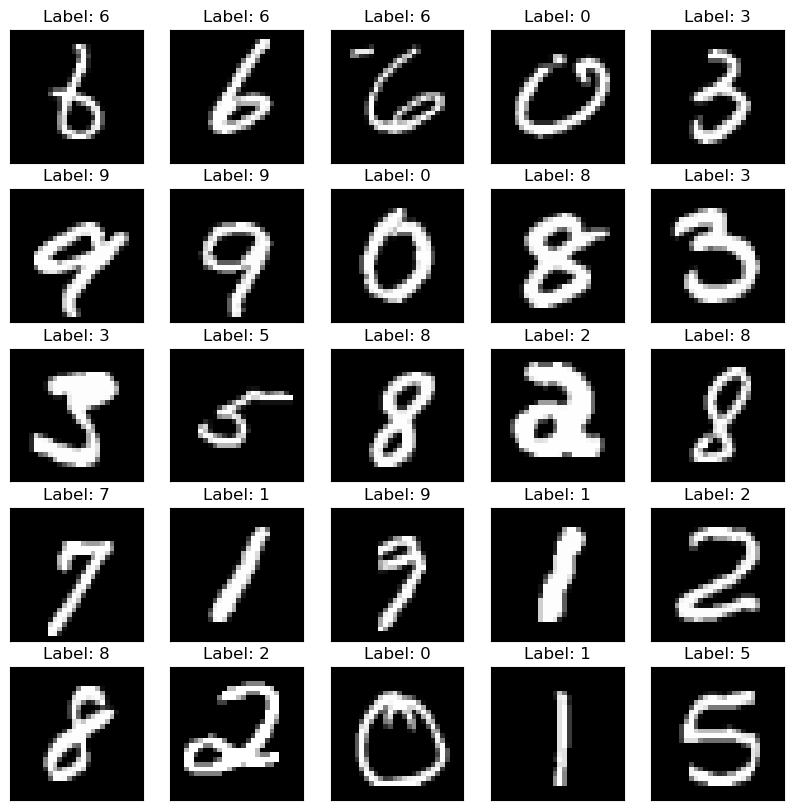

In [7]:
fig, axs = plt.subplots(5, 5, figsize = (10, 10))

for ax in axs.flatten():
   img, label = random.choice(trainDataset)
   ax.imshow(np.array(img), cmap = 'gist_gray')
   ax.set_title(f'Label: {label}')
   ax.set_xticks([])
   ax.set_yticks([])

In [8]:
#Transforms in pytorch tensors
trainTransform = transforms.Compose([transforms.ToTensor(),])
testTransform = transforms.Compose([transforms.ToTensor(),])

trainDataset.transform = trainTransform
testDataset.transform = testTransform

In [9]:
#Define the Dataloader
trainDataloader = DataLoader(trainDataset, batch_size=256, shuffle=True)
testDataloader = DataLoader(testDataset, batch_size=256, shuffle=False)

batch_data, batch_labels = next(iter(trainDataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(testDataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


# VAE model

## Set up model

In [10]:
model = VariationalAutoEncoder(latentDim = 10, hiddenDim=[200, 150, 100])

In [11]:
loss_fn = torch.nn.MSELoss()

lr = 5e-4
parameToOptimize = [
   {'params': model.parameters()}
]

optim = torch.optim.Adam(parameToOptimize, lr = lr)
if torch.backends.mps.is_available():
   device = torch.device("mps")
elif torch.cuda.is_available():
   device = torch.device("cuda")
else:
   device = torch.device("cpu")

print(f'Selected device: {device}')

model.to(device)

Selected device: cuda


VariationalAutoEncoder(
  (Encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=200, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=200, out_features=150, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=150, out_features=100, bias=True)
      (1): ReLU()
    )
  )
  (LatentLayerMu): Linear(in_features=100, out_features=10, bias=True)
  (LatentLayerSigma): Linear(in_features=100, out_features=10, bias=True)
  (LatentSpace): Identity()
  (Decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=100, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=150, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=150, out_features=200, bias=True)
      (1): ReLU()
    )
  )
  (OutputLayer): Linear(in_features=200, out_features=784, bias=True)
  (OutputSpace): Ident

## Training Model

In [12]:
def Training(model, num_epochs=10, showImage=False):
    setup_hooks(model)

    for epoch in range(num_epochs):
        model.train()
        losses = []

        for images, _ in tqdm(trainDataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)

            outputs, z = model(images) #outputs, z, mean, std
            targets = images.view(images.size(0), -1)

            loss = loss_fn(outputs, targets)

            optim.zero_grad()
            loss.backward()
            optim.step()

            losses.append(loss.detach().cpu().numpy())

        # Computing Mutual Info
        res = VAE_info(model, trainDataset, device=device)
        history_encoder.append(res['encoder'])
        history_decoder.append(res['decoder'])

        avg_loss = np.mean(losses)
        print(f"TRAIN — Epoch {epoch+1}/{num_epochs} — loss: {avg_loss:.4f}")

        if showImage:
            model.eval()

            img = testDataset[0][0].unsqueeze(0).to(device)

            with torch.no_grad():
                recon = model(img)[0]

            fig, axs = plt.subplots(1, 2, figsize=(12, 6))

            axs[0].imshow(img.cpu().squeeze(), cmap='gist_gray')
            axs[0].set_title("Original image")

            axs[1].imshow(recon.cpu().squeeze().reshape(28, 28), cmap='gist_gray')
            axs[1].set_title(f"Reconstruction (epoch {epoch+1})")

            plt.tight_layout()
            plt.show()
            plt.close()

    return np.mean(losses)

Epoch 1/3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:04<00:00, 57.89it/s]


TRAIN — Epoch 1/3 — loss: 0.0800


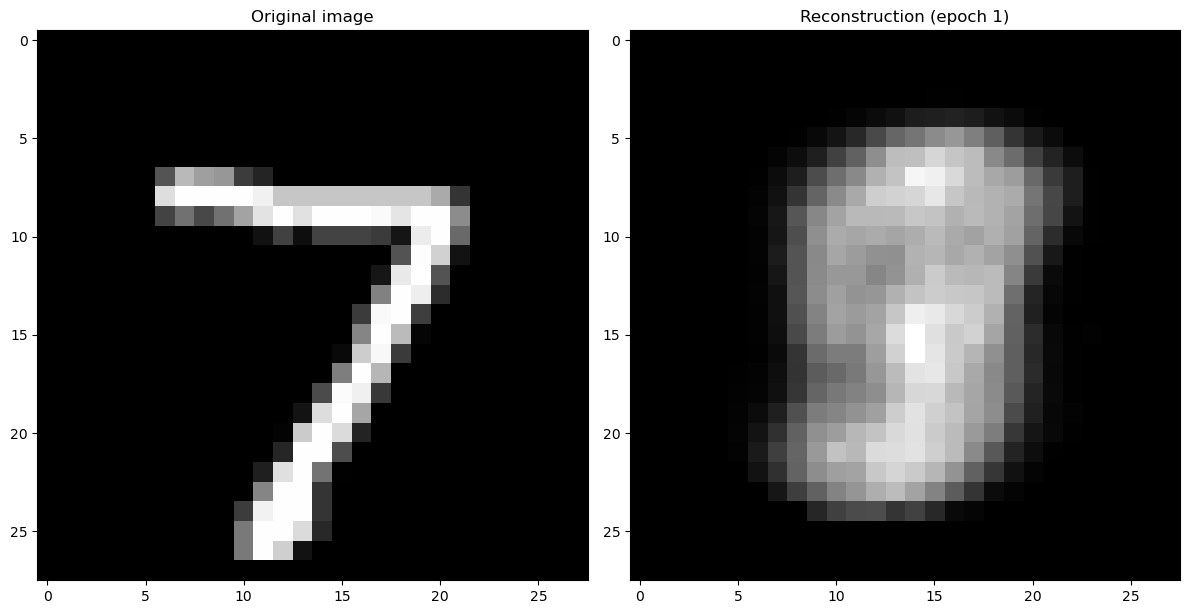

Epoch 2/3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:04<00:00, 58.31it/s]


TRAIN — Epoch 2/3 — loss: 0.0523


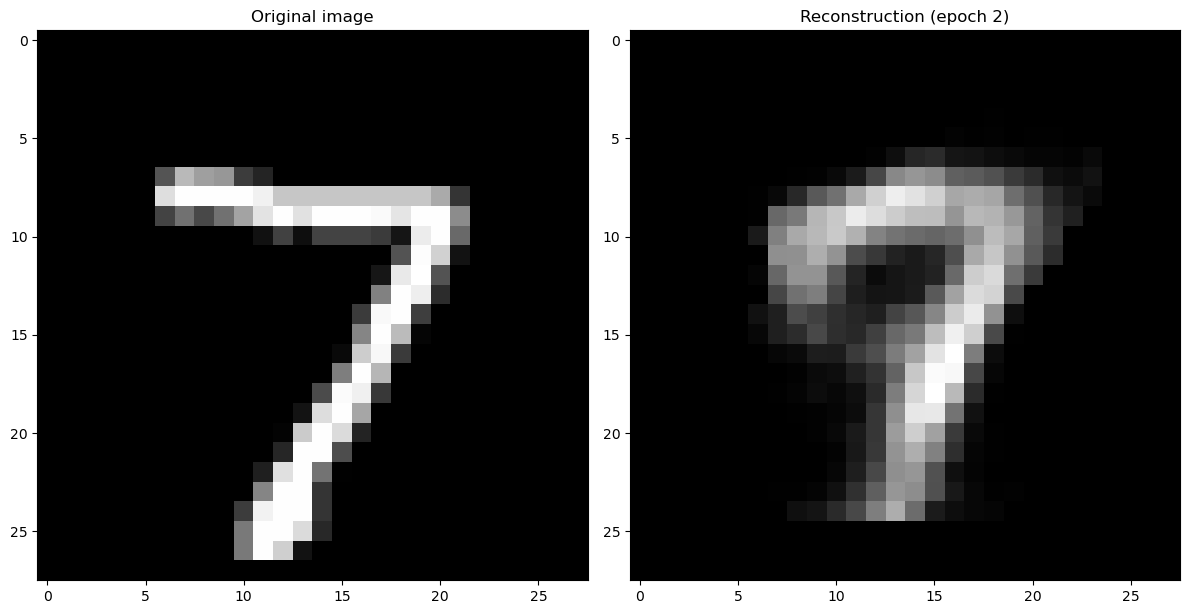

Epoch 3/3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:03<00:00, 59.44it/s]


TRAIN — Epoch 3/3 — loss: 0.0394


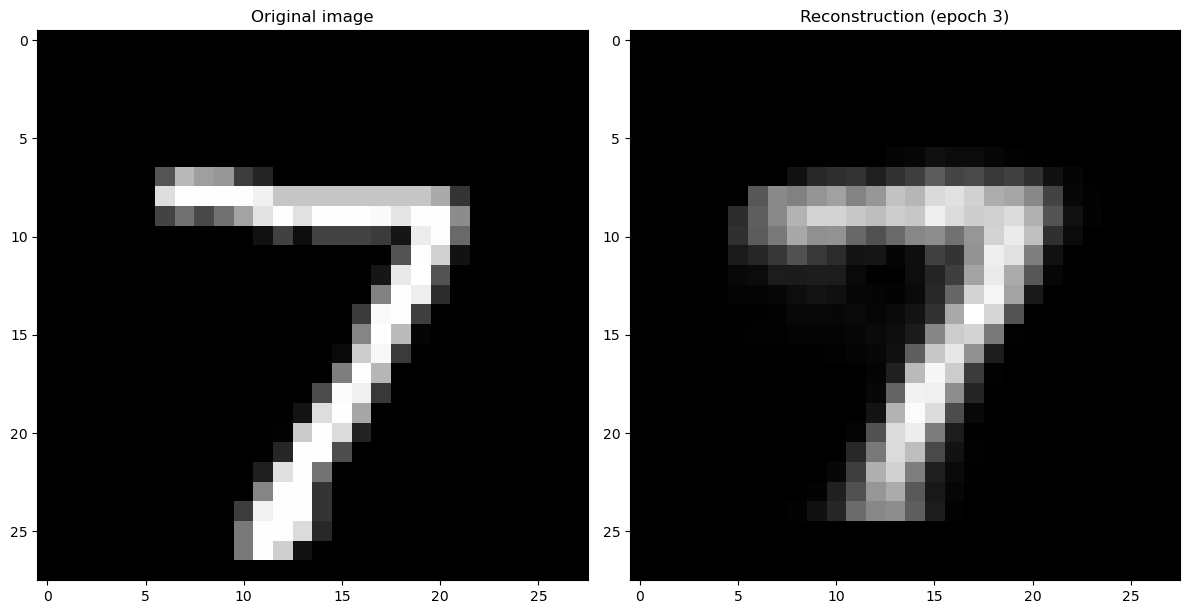

In [13]:
final_loss = Training(model, num_epochs=3, showImage=True)

# Results

## Debug

In [14]:
activations

{'encoder_layer_1': tensor([[7.6204e-01, 1.1246e+00, 5.3123e-01, 1.3698e+00, 1.0791e+00, 2.8687e+00,
          4.2627e-02, 0.0000e+00, 3.3713e-01, 1.0423e-01, 1.8040e-01, 0.0000e+00,
          4.9974e-01, 6.7834e-01, 8.8139e-01, 2.3063e-03, 6.2259e-01, 7.8394e-01,
          1.2181e+00, 4.6389e-01, 2.1129e+00, 2.8719e-01, 6.1702e-01, 9.3083e-01,
          7.5840e-01, 8.2404e-01, 1.1071e+00, 4.8416e-01, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 4.2678e-01, 1.2406e+00, 1.2751e+00, 5.5913e-01, 0.0000e+00,
          1.5715e+00, 8.8321e-01, 1.4787e-01, 1.5213e+00, 4.8823e-01, 2.3303e-01,
          9.3536e-01, 1.7540e+00, 1.8834e+00, 1.2258e+00, 8.8240e-01, 1.2077e+00,
          1.2987e+00, 0.0000e+00, 1.1480e+00, 0.0000e+00, 1.9245e-01, 8.3991e-01,
          9.8780e-01, 0.0000e+00, 9.1098e-01, 8.2997e-01, 0.0000e+00, 8.3269e-01,
          6.1148e-01, 7.4895e-01, 1.2249e+00, 6.0657e-01, 2.2438e-01, 0.0000e+00,
          2.0866e-01, 2.0497e-02, 2.4199e+00, 2.0539e-01, 7.6742e-01, 5.2349e-0

In [17]:
a = activations['decoder_layer_1'].detach().cpu().numpy()[0]
print(len(a),"\n",a)

100 
 [10.390368    0.          5.0928655   0.8957137   0.          8.157437
  3.6908321   0.7279346   0.69492793  3.447381   10.872099    0.
  2.1469727   0.          0.          5.331267    3.0185297   1.5998006
  5.2229385   6.3462777   1.6990292   0.          0.19112638  1.4900721
  7.4028444   1.0322645   3.6931484   3.6178958   0.          0.
  2.1472173   0.          1.074142    2.0235736   0.          2.0523074
  3.4885228   0.          2.7571473   2.369258    8.466316    0.
  0.          0.          3.897088    9.401846    0.7657769   0.
  1.7639592   0.          1.9071324   5.1766872   4.32545     2.3059626
  0.          2.8476884   0.          4.35326     6.226015    0.95114505
  0.          2.6848493   1.4831461   0.          0.          1.7414494
  0.9770831   0.          2.9867802   8.506815    1.5604874   5.763918
  0.          0.65844935  6.0603933   0.38073948  6.687348    6.2381563
  9.598576    1.4329772   0.          0.          0.          3.67947
  4.8488026   6.4

In [18]:
history_encoder

[[(np.float32(6.907699), np.float32(6.9075036)),
  (np.float32(6.902845), np.float32(6.9026766)),
  (np.float32(6.8691936), np.float32(6.8682857))],
 [(np.float32(6.907627), np.float32(6.907853)),
  (np.float32(6.9080286), np.float32(6.9079833)),
  (np.float32(6.9070144), np.float32(6.9079566))],
 [(np.float32(6.907589), np.float32(6.9073753)),
  (np.float32(6.90768), np.float32(6.9073915)),
  (np.float32(6.905085), np.float32(6.9078546))]]

In [19]:
history_decoder

[[(np.float32(6.907534), np.float32(6.040154)),
  (np.float32(6.90822), np.float32(6.0406647)),
  (np.float32(6.9065037), np.float32(6.037956))],
 [(np.float32(6.906893), np.float32(6.895132)),
  (np.float32(6.9082084), np.float32(6.894932)),
  (np.float32(6.910697), np.float32(6.8937674))],
 [(np.float32(6.9074173), np.float32(6.9012165)),
  (np.float32(6.908852), np.float32(6.900462)),
  (np.float32(6.906576), np.float32(6.89962))]]

## Utilities Mutual Info

In [20]:
def PlotInfoPlane(mi_history_encoder, mi_history_decoder, title_suffix=""):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    epochs = len(mi_history_encoder)
    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, epochs)]

    ax = axes[0]
    n_layers = len(mi_history_encoder[0])

    for l in range(n_layers):
        x = [e[l][0] for e in mi_history_encoder]
        y = [e[l][1] for e in mi_history_encoder]
        ax.plot(x, y, color='gray', alpha=0.3)
        ax.scatter(x, y, c=colors, s=20)

    ax.set_xlabel("I(Layer; Input)")
    ax.set_ylabel("I(Layer; Latent Z)")
    ax.set_title(f"Encoder information plane {title_suffix}")

    ax = axes[1]
    n_layers = len(mi_history_decoder[0])

    for l in range(n_layers):
        x = [e[l][0] for e in mi_history_decoder]
        y = [e[l][1] for e in mi_history_decoder]
        ax.plot(x, y, color='gray', alpha=0.3)
        ax.scatter(x, y, c=colors, s=20)

    ax.set_xlabel("I(Layer; Latent Z)")
    ax.set_ylabel("I(Layer; Output)")
    ax.set_title(f"Decoder information plane {title_suffix}")

    plt.colorbar(
        plt.cm.ScalarMappable(cmap=cmap),
        ax=axes.ravel().tolist(),
        label="Training epoch"
    )

    plt.show()

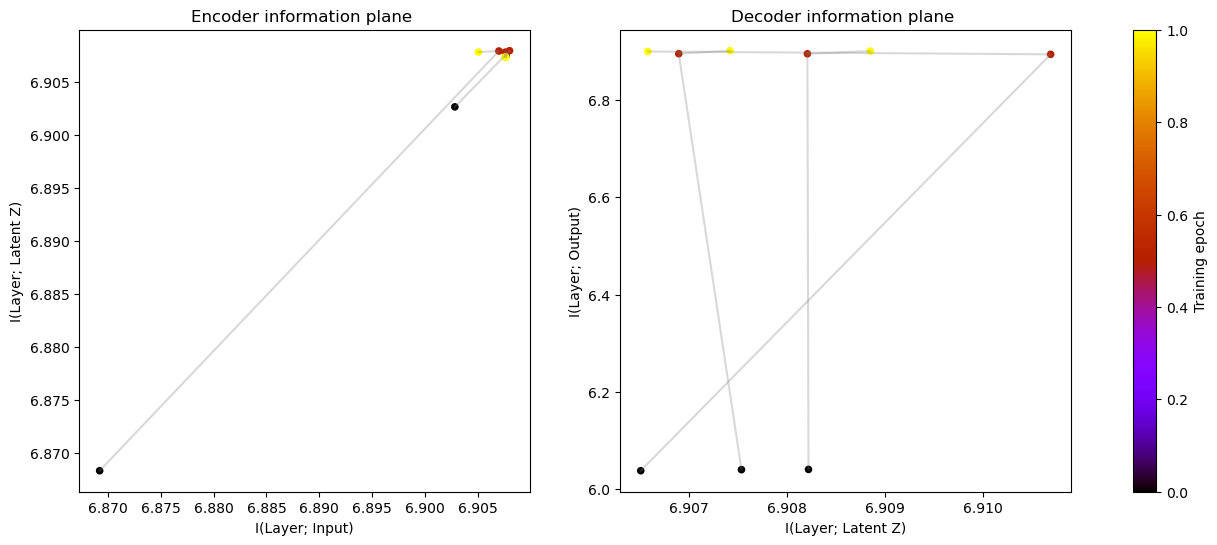

In [21]:
PlotInfoPlane(history_encoder, history_decoder)